## Usage of DeepResolution2

### Here, a simulated data is taken as an example to show the process of DeepResolution2.

#### Prepare the data.
A GC-MS slice contains two overlapped segments, namely a three-component overlapped peak and a two-component overlapped peak.

In [1]:
import numpy as np
from tensorflow.python.framework import ops  
import matplotlib.pyplot as plt
from scipy.stats import binom, norm, beta, expon
import tensorflow as tf
from DeepResolution2.UNet4S import UNet4S
from DeepResolution2.kCNN import kCNN
from DeepResolution2.UNet4R import UNet4R
from DeepResolution2.MCR_ALS import mcr_als
from DeepResolution2.DeepResolution2 import MCR

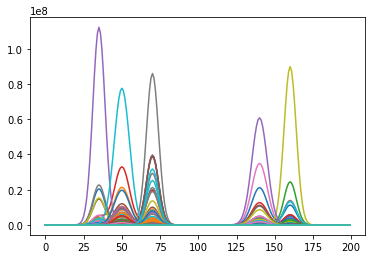

In [2]:
chrom = np.load('C:/Users/admin/Desktop/DeepResolution2_upload/Example.npy')
plt.figure()
plt.plot(chrom)  
plt.show() 

#### U-Net4S
Deep neural network based on U-Net for automatic chromatogram Segmentation.

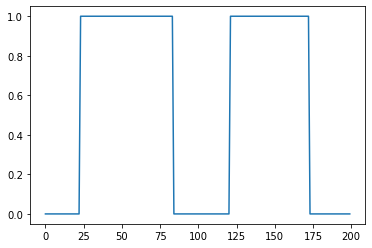

In [3]:
tf.keras.backend.clear_session()
ops.reset_default_graph()

m = {'rt':np.arange(0,200,1),'mz':np.arange(1,801,1),'d':chrom}
model_size=128
work_path = 'C:/Users/admin/Desktop/DeepResolution2_upload'
result_path = []
restored_model = tf.keras.models.load_model(work_path+'/model/UNet4S/model.h5') 
y_DeepSeg,ind_st_DeepSeg,ind_en_DeepSeg = UNet4S(work_path,m,model_size,distance=5,threshold=15)  
peak_show = np.sum(y_DeepSeg,1)
peak_show[peak_show>1]=1
peak_show[peak_show<1]=0
plt.figure()
plt.plot(peak_show)
plt.show()

#### k-CNN
Convolutional Neural Network automatically determines the number of components k presenting in each GC-MS data segment.

In [4]:
PCA = kCNN(work_path,m,ind_st_DeepSeg,ind_en_DeepSeg,model_size)
print(PCA)

[3 2]


#### U--Net4R and Resolution
Deep neural network based on U-Net for elution Region detection.
Deep learning-assisted Multivariate Curve Resolution.
Segments with the same number of components are handling at the same time to speed up the prediction and resolution.

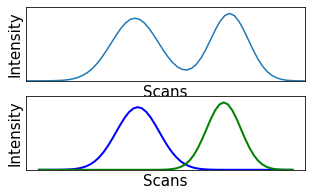

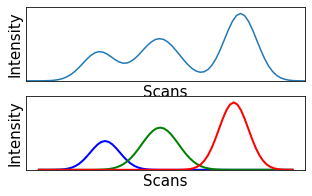

In [10]:
COMs = [1,2,3,4,5]
method = 'MCRALS'
for COMi in range(len(COMs)):
    COM=COMs[COMi]
 
    PC = [idx for idx,i in enumerate(PCA) if i==COM] 
    if len(PC)!=0:

        ind_st_DeepSegC = np.array(ind_st_DeepSeg,dtype='int')[PC]
        ind_en_DeepSegC = np.array(ind_en_DeepSeg,dtype='int')[PC]

        
        y_UNet4R_pre,S_EFA = UNet4R(work_path,m,ind_st_DeepSegC,ind_en_DeepSegC,model_size,COM)
        

        for M in range(y_UNet4R_pre.shape[0]):
            XM = m['d'][ind_st_DeepSegC[M]:ind_en_DeepSegC[M],:] 
            
            y_UNet4R_M = np.zeros((int(2*COM),XM.shape[0]))
            S = np.zeros((int(2*COM),XM.shape[0]))
            for j in range(COM,int(2*COM)):           
                y_UNet4R_pre[M,j,:,1] = np.flip(y_UNet4R_pre[M,j,:,1],0)
                S_EFA[M,j,:,0] = np.flip(S_EFA[M,j,:,0],0)

            y_UNet4R_M[0:COM,0:XM.shape[0]] = y_UNet4R_pre[M,0:COM,0:XM.shape[0],1]
            y_UNet4R_M[COM:int(2*COM),0:XM.shape[0]] = y_UNet4R_pre[M,COM:int(2*COM),int(model_size-XM.shape[0]):model_size,1]  

            S[0:COM,0:XM.shape[0]] = S_EFA[M,0:COM,0:XM.shape[0],0]
            S[COM:int(2*COM),0:XM.shape[0]] = S_EFA[M,COM:int(2*COM),int(model_size-XM.shape[0]):model_size,0]

            MCR_result = MCR(XM,y_UNet4R_M,COM,method,ind_st_DeepSegC[M],ind_en_DeepSegC[M],m['rt'],result_path)

The total ion chromatogram (top) and resolution result (bottom).